In [1]:
import toml
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import seaborn as sns

In [2]:
scan_path = Path('/n/groups/datta/win/longtogeny/size_norm/models/big_param_scan_00')

In [6]:
def get_mag(s):
    if s == 'K':
        return 1e3
    elif s == 'M':
        return 1e6
    elif s == 'B':
        return 1e9
    else:
        raise NotImplementedError()

## Stage 1

In [7]:
metrics = list(scan_path.glob("stage_01/**/metrics.csv"))

In [23]:
results = []
for f in tqdm(metrics):
    folder = f.parents[2]
    config = toml.load(folder / "config.toml")
    mse_df = pd.read_csv(f)
    tmp = mse_df.groupby('epoch').mean()
    with open(list(folder.glob('model*.out'))[0], 'r') as out_f:
        for line in out_f.readlines():
            if "Total params" in line:
                params = line.split(' ')[:2]
                params = float(params[0]) * get_mag(params[1])
    out = dict(
        depth=config['model']['depth'],
        arch=config['model']['lightning']['arch'],
        channel_scaling=config['model']['channel_scaling'],
        depth_scaling=config['model']['depth_scaling'],
        init_depth=config['model']['init_depth'],
        init_channel=config['model']['init_channel'],
        val_mse=None if 'val_loss' not in mse_df.columns else mse_df['val_loss'].min(),
        uuid=folder.name,
        train_mse=tmp['train_loss'].min(),
        epoch=mse_df['epoch'].max(),
        param_count=params,
        file=str(folder / "model.pt"),
        activation=config['model']['activation'],
    )
    if 'dynamics_correlation' in mse_df.columns:
        out['dynamics_corr'] = mse_df['dynamics_correlation'].dropna().iloc[-1]
    if 'age_classification' in mse_df.columns:
        out['age_class'] = mse_df['age_classification'].dropna().iloc[-1]
    results.append(out)
results = pd.DataFrame(results)

  0%|          | 0/171 [00:00<?, ?it/s]

In [24]:
results[['param_count', 'epoch']]

,param_count,epoch
0,5600000.0,100
1,123000000.0,12
2,4100000.0,75
3,87200.0,100
4,1800000.0,100
...,...,...
166,271000.0,100
167,1000000.0,100
168,31500000.0,70
169,775000000.0,0


In [25]:
results['init_channel'].unique()

array([ 16, 512, 256,   4,  32,  64,   8, 128])

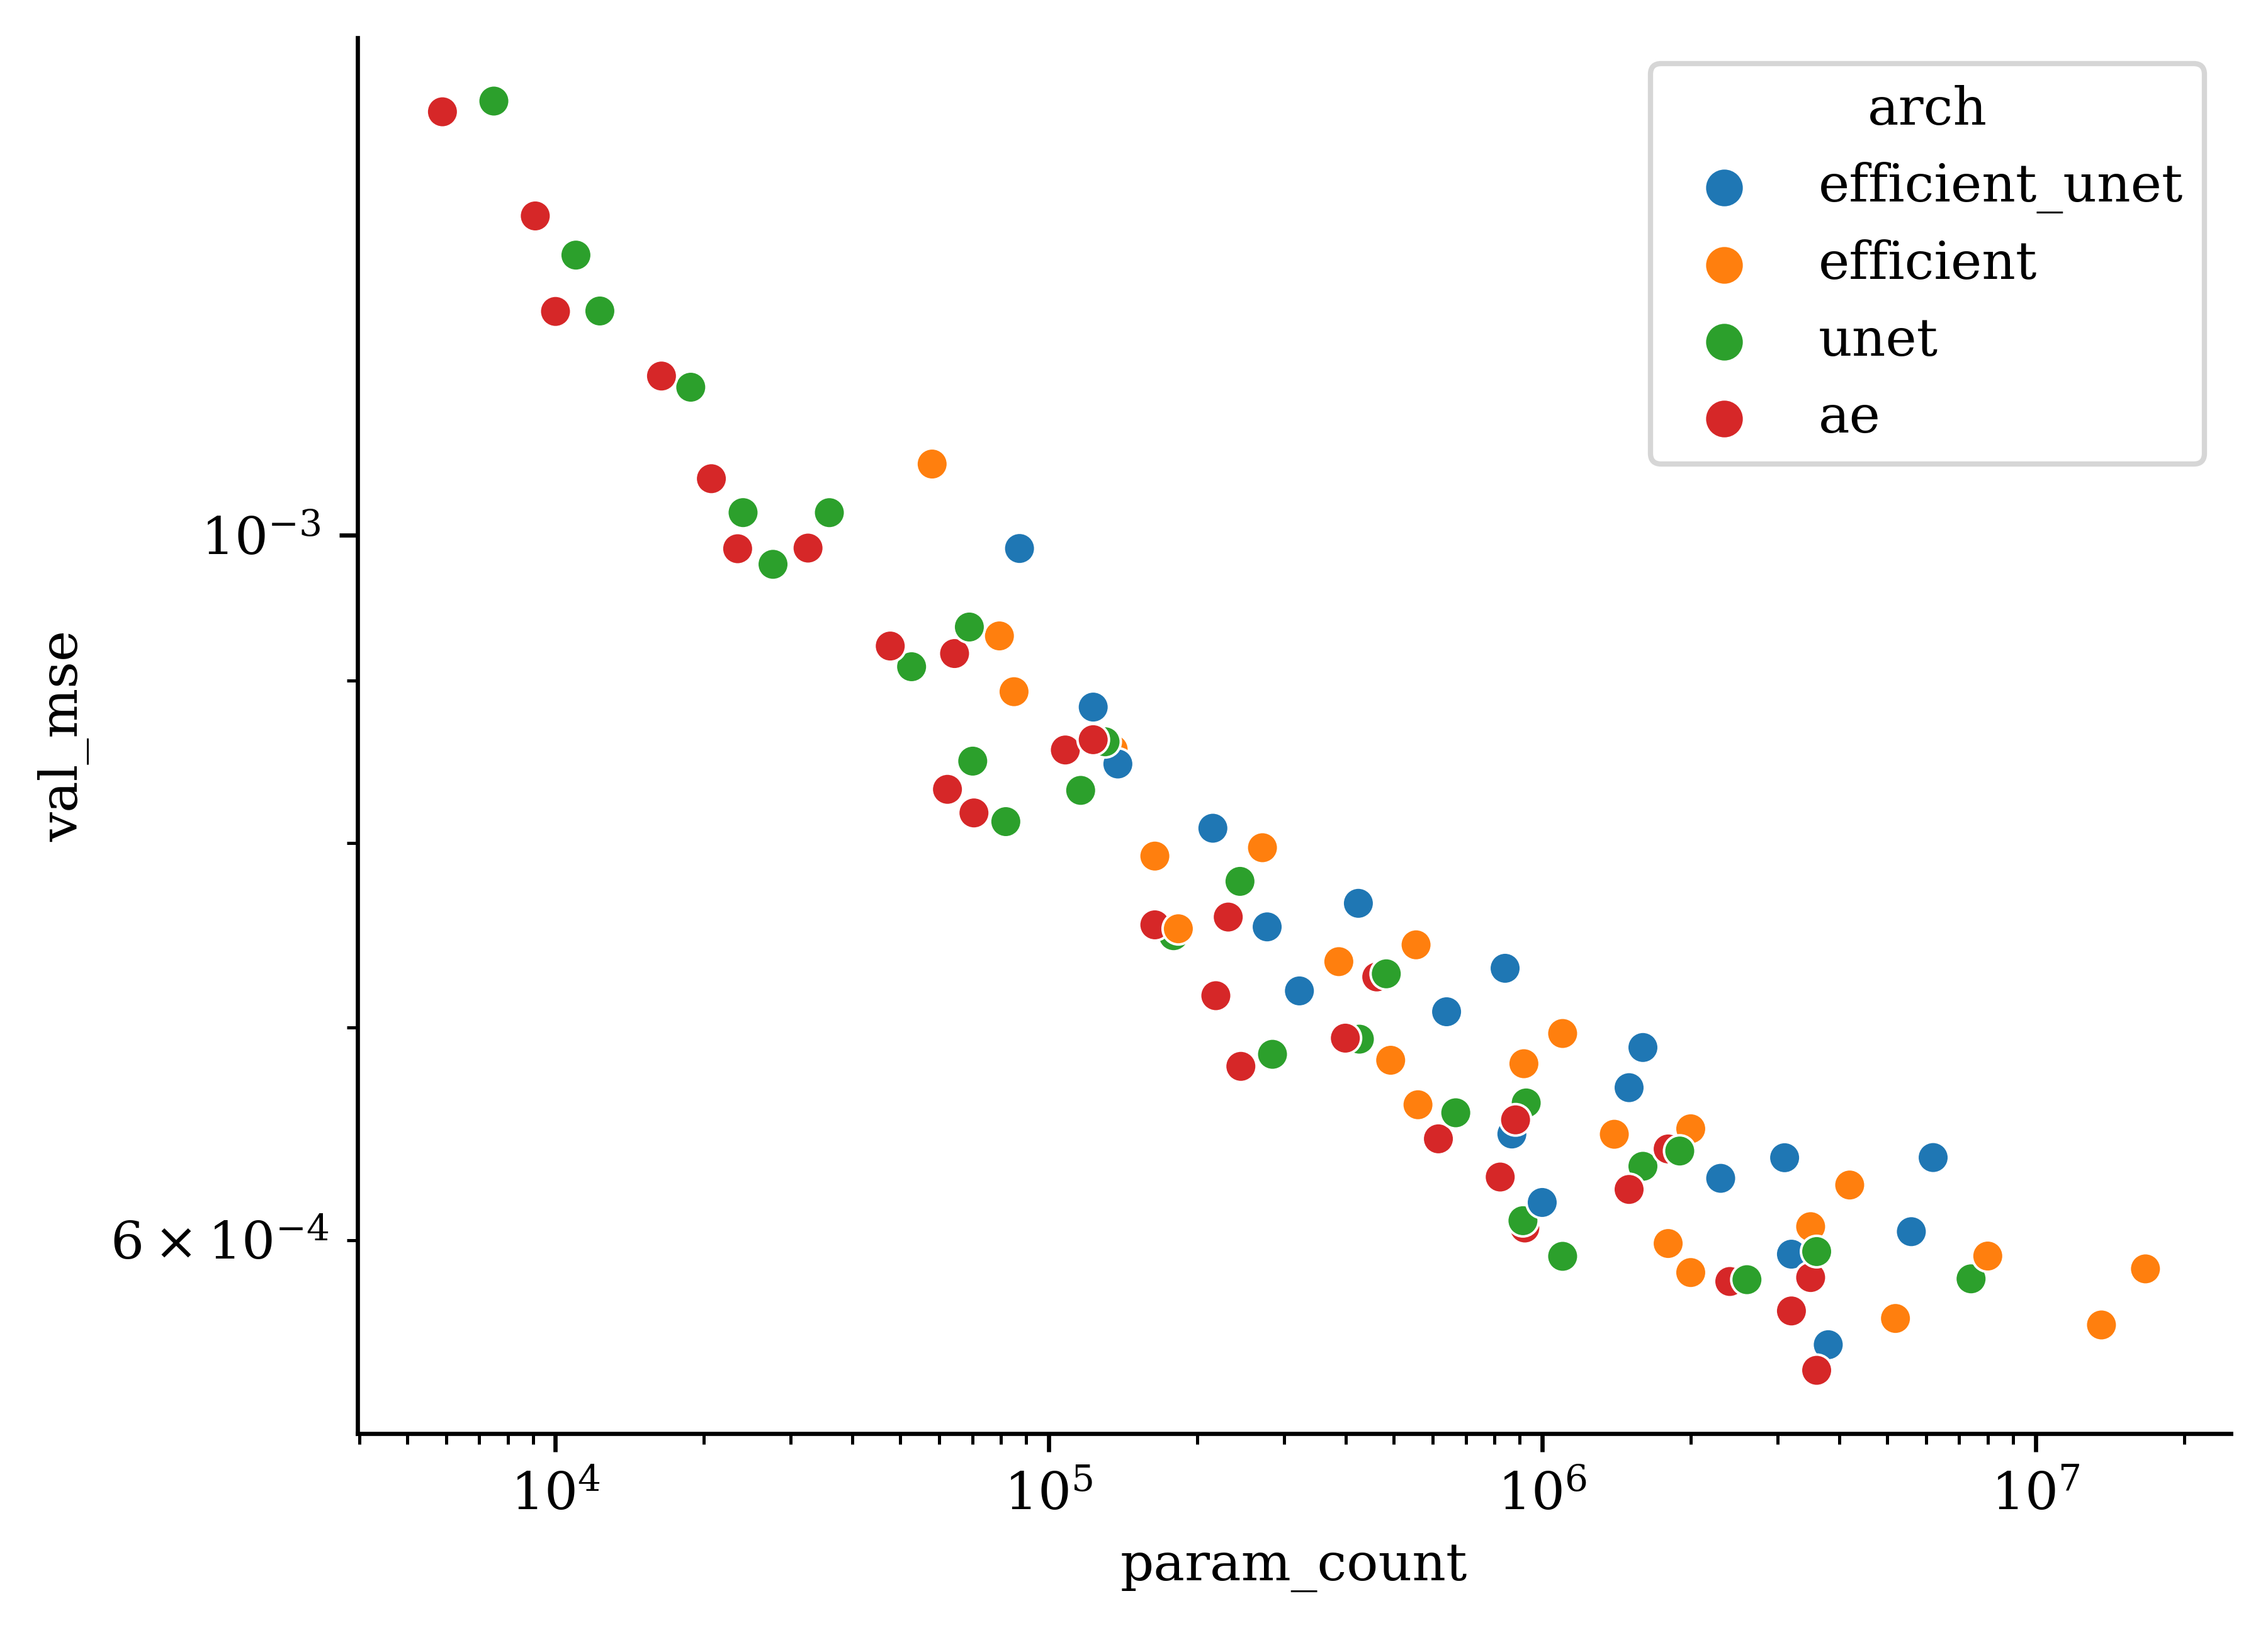

In [26]:
ax = sns.scatterplot(data=results.query('epoch == 100'), x='param_count', y='val_mse', hue='arch')
ax.set(xscale='log', yscale='log')
sns.despine()

In [39]:
results.loc[results.query('epoch == 100')['val_mse'].idxmin()]

depth                                                              4
arch                                                              ae
channel_scaling                                                  1.5
depth_scaling                                                    1.0
init_depth                                                         1
init_channel                                                     256
val_mse                                                     0.000546
uuid                            fbe6efe5-9c3a-4228-b643-e16f3520f893
train_mse                                                   0.000506
epoch                                                            100
param_count                                                3600000.0
file               /n/groups/datta/win/longtogeny/size_norm/model...
dynamics_corr                                               0.835525
age_class                                                   0.245719
Name: 155, dtype: object

In [38]:
results.loc[results.query('epoch == 100')['dynamics_corr'].idxmax()]

depth                                                              4
arch                                                            unet
channel_scaling                                                  2.5
depth_scaling                                                    1.0
init_depth                                                         1
init_channel                                                      64
val_mse                                                     0.000583
uuid                            f026ff89-de2b-4789-9985-f4cc02179b0b
train_mse                                                   0.000533
epoch                                                            100
param_count                                                2600000.0
file               /n/groups/datta/win/longtogeny/size_norm/model...
dynamics_corr                                               0.847298
age_class                                                   0.253719
Name: 35, dtype: object

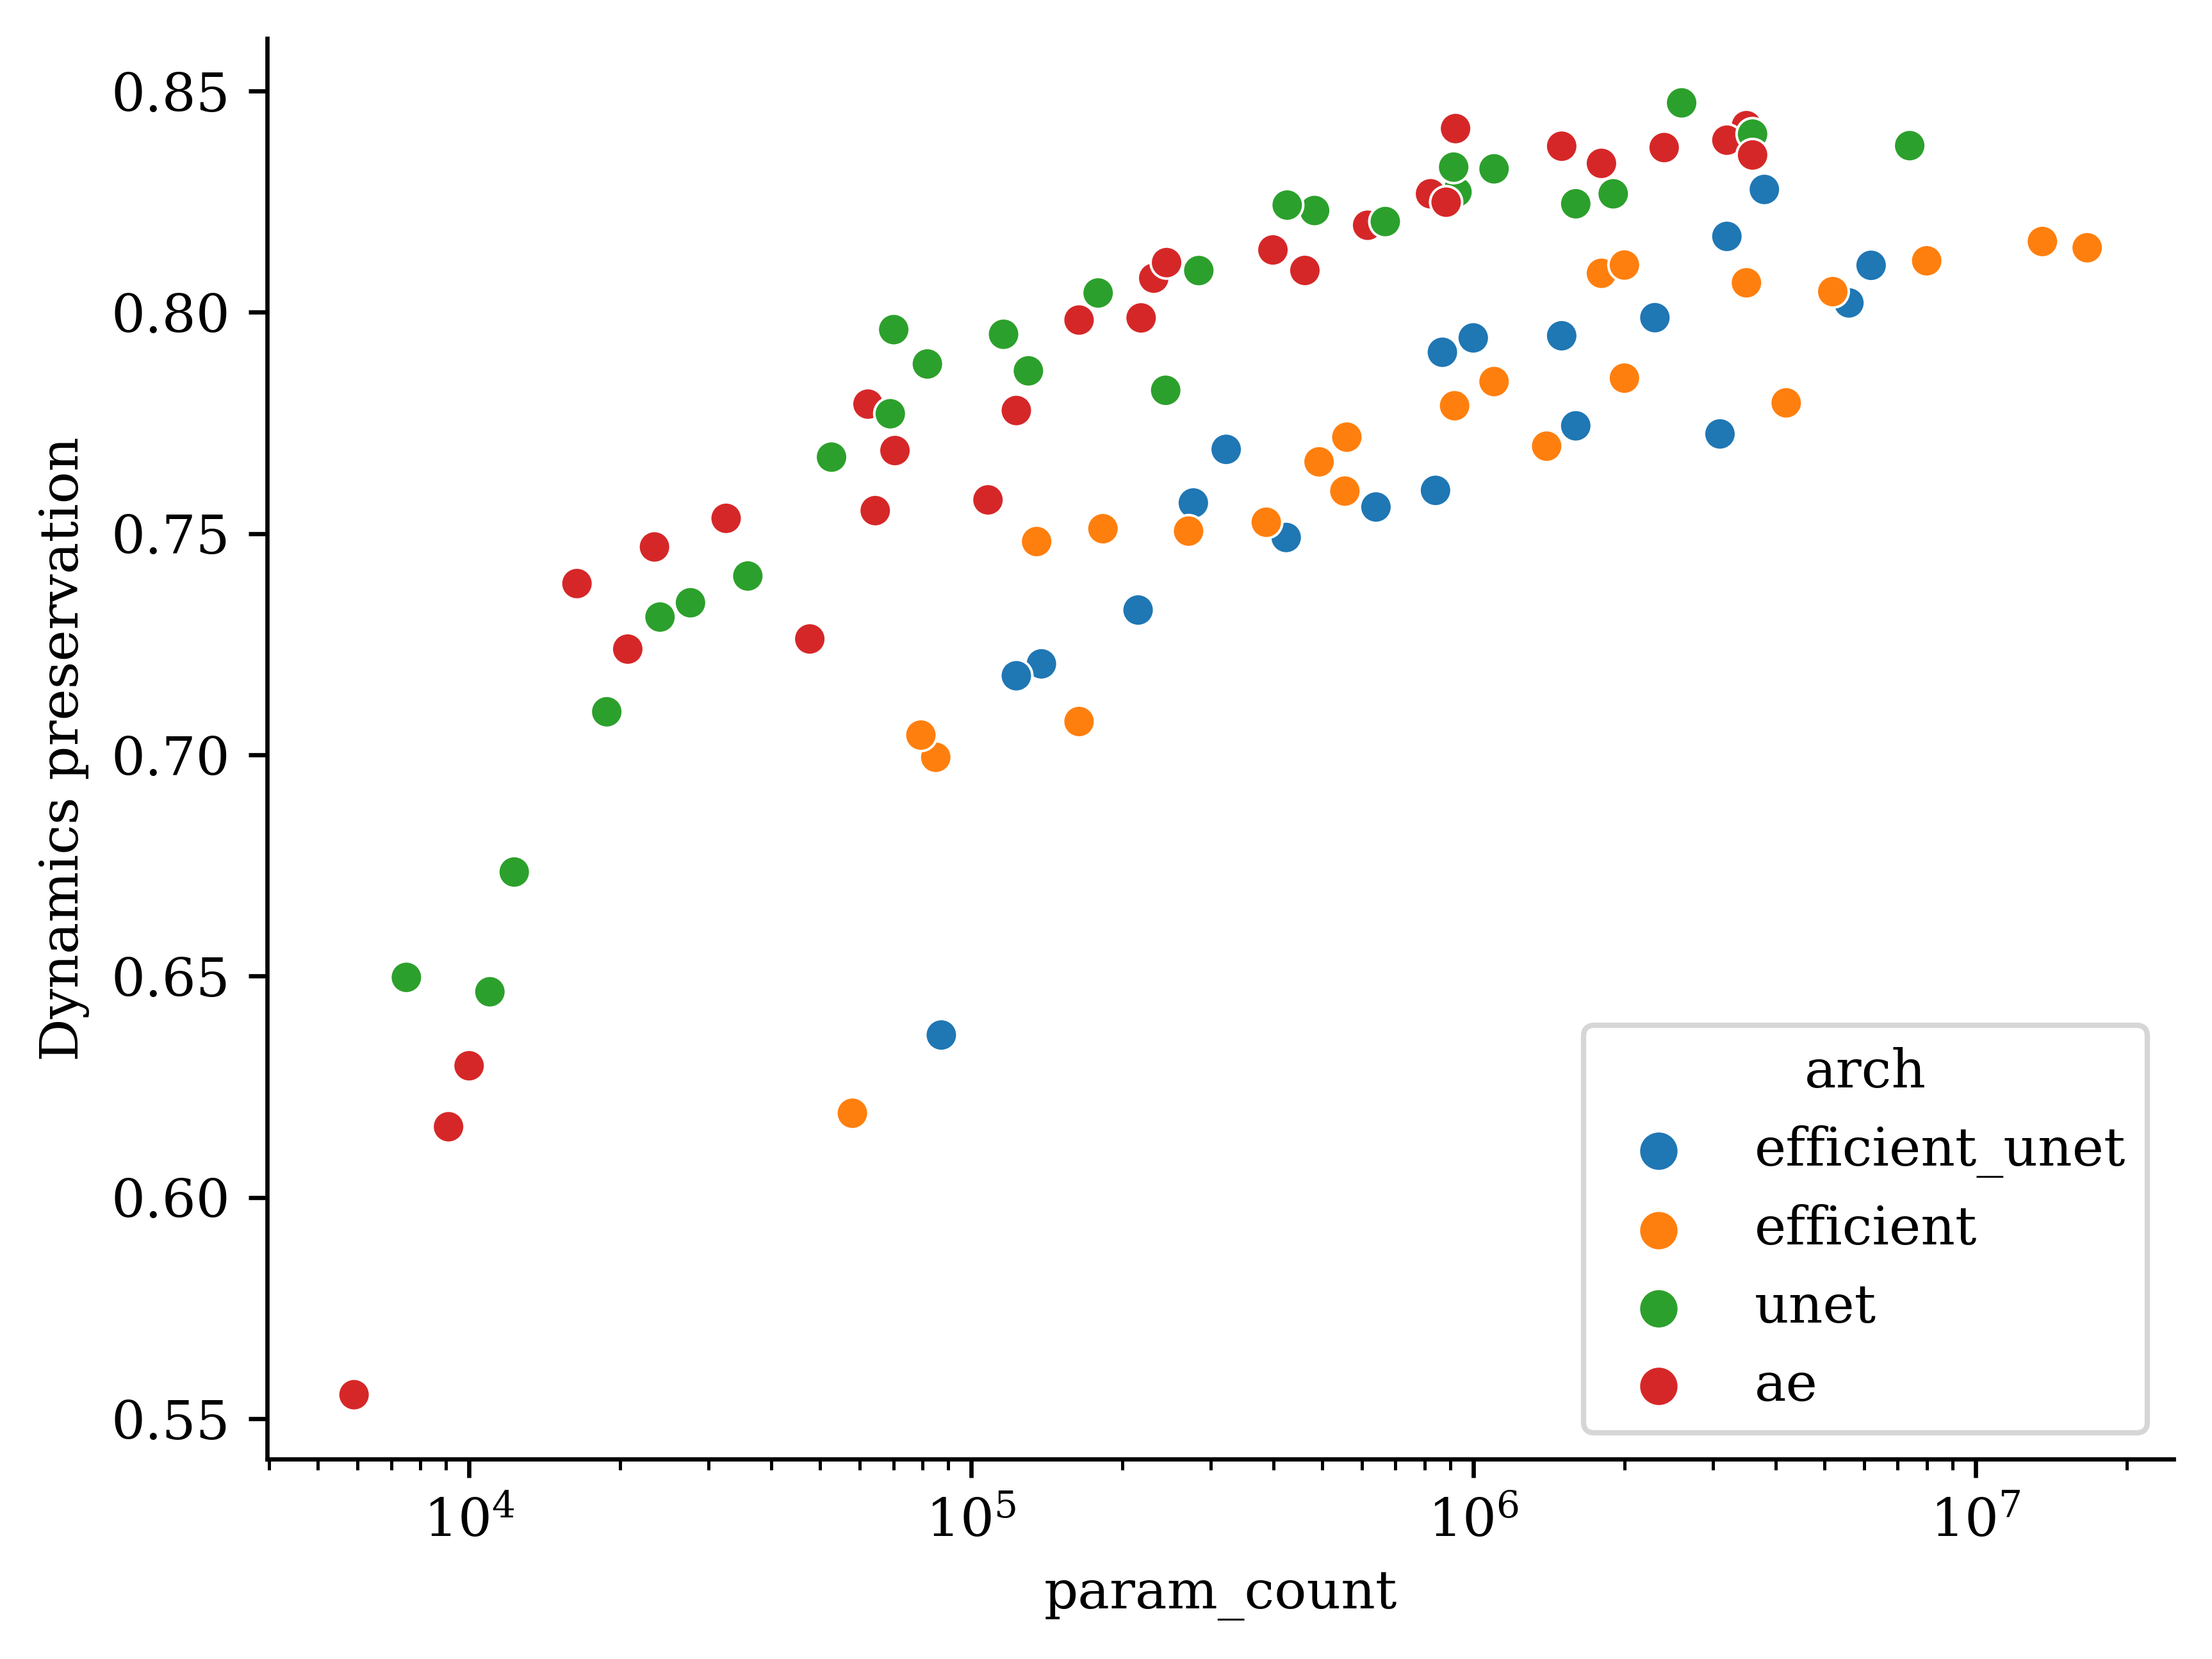

In [34]:
ax = sns.scatterplot(
    data=results.query("epoch == 100"), x="param_count", y="dynamics_corr", hue="arch"
)
ax.set(xscale="log", ylabel="Dynamics preservation")
sns.despine()

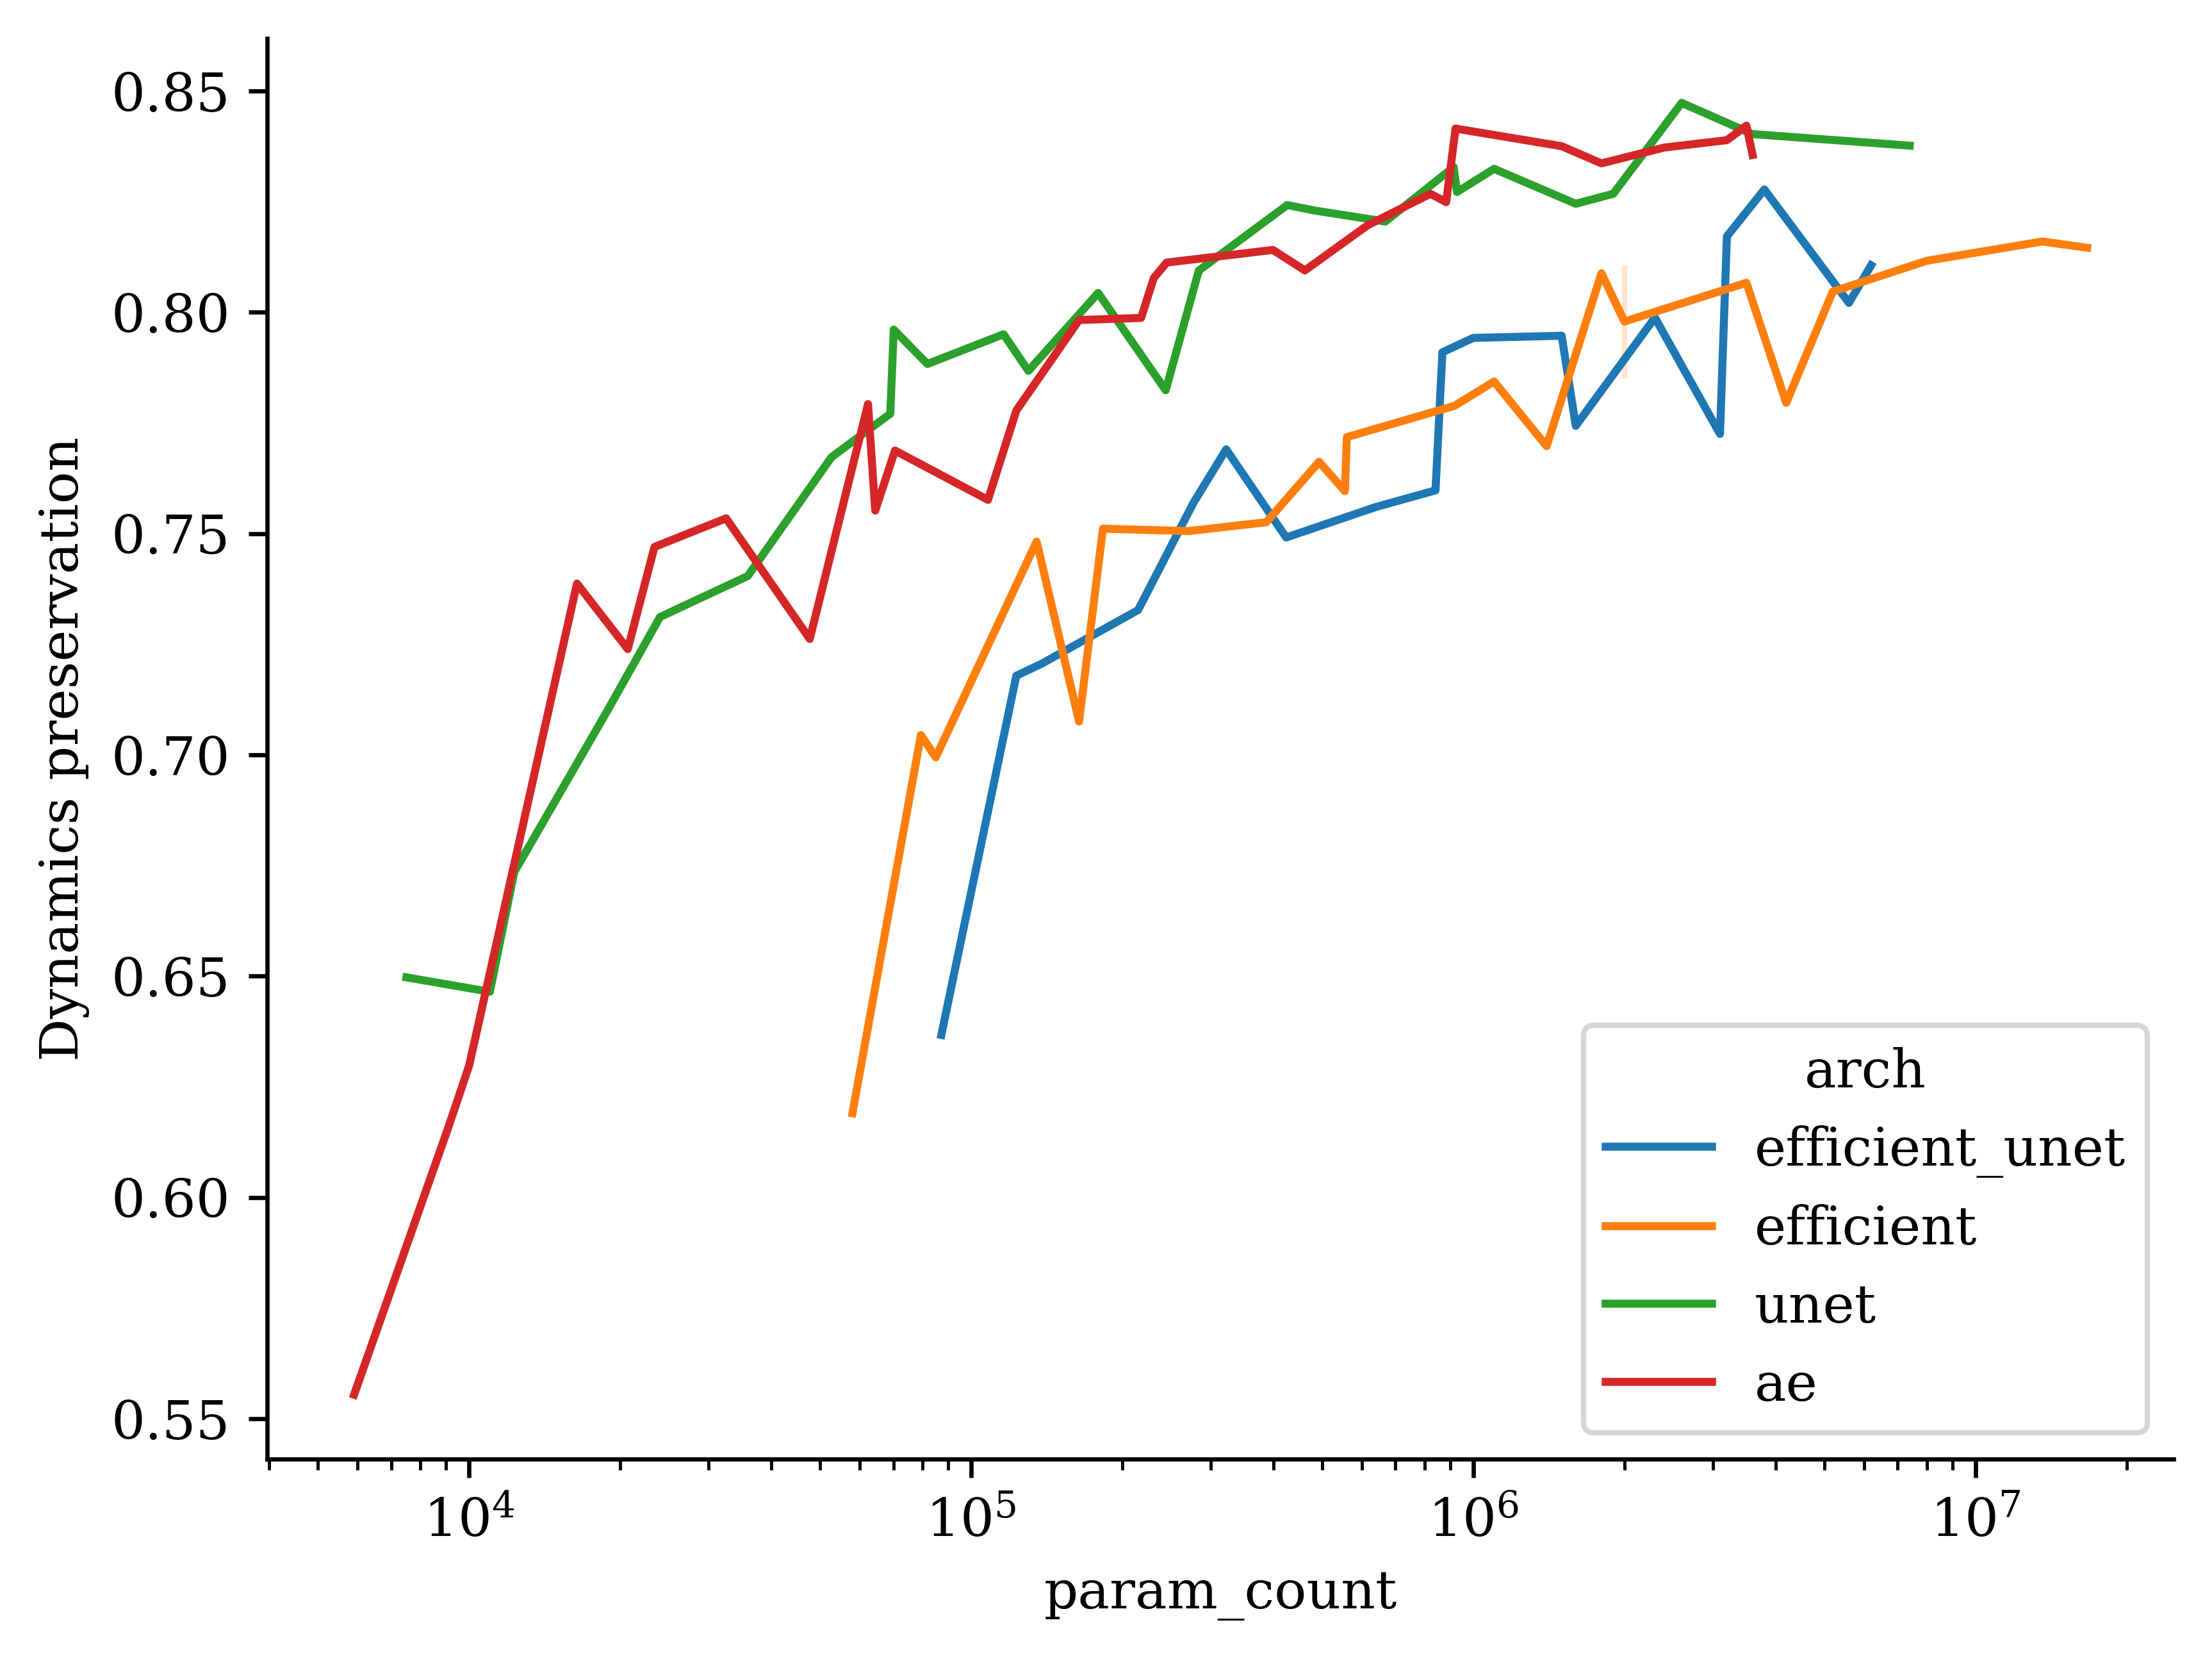

In [60]:
ax = sns.lineplot(
    data=results.query("epoch == 100"), x="param_count", y="dynamics_corr", hue="arch"
)
ax.set(xscale="log", ylabel="Dynamics preservation")
sns.despine()

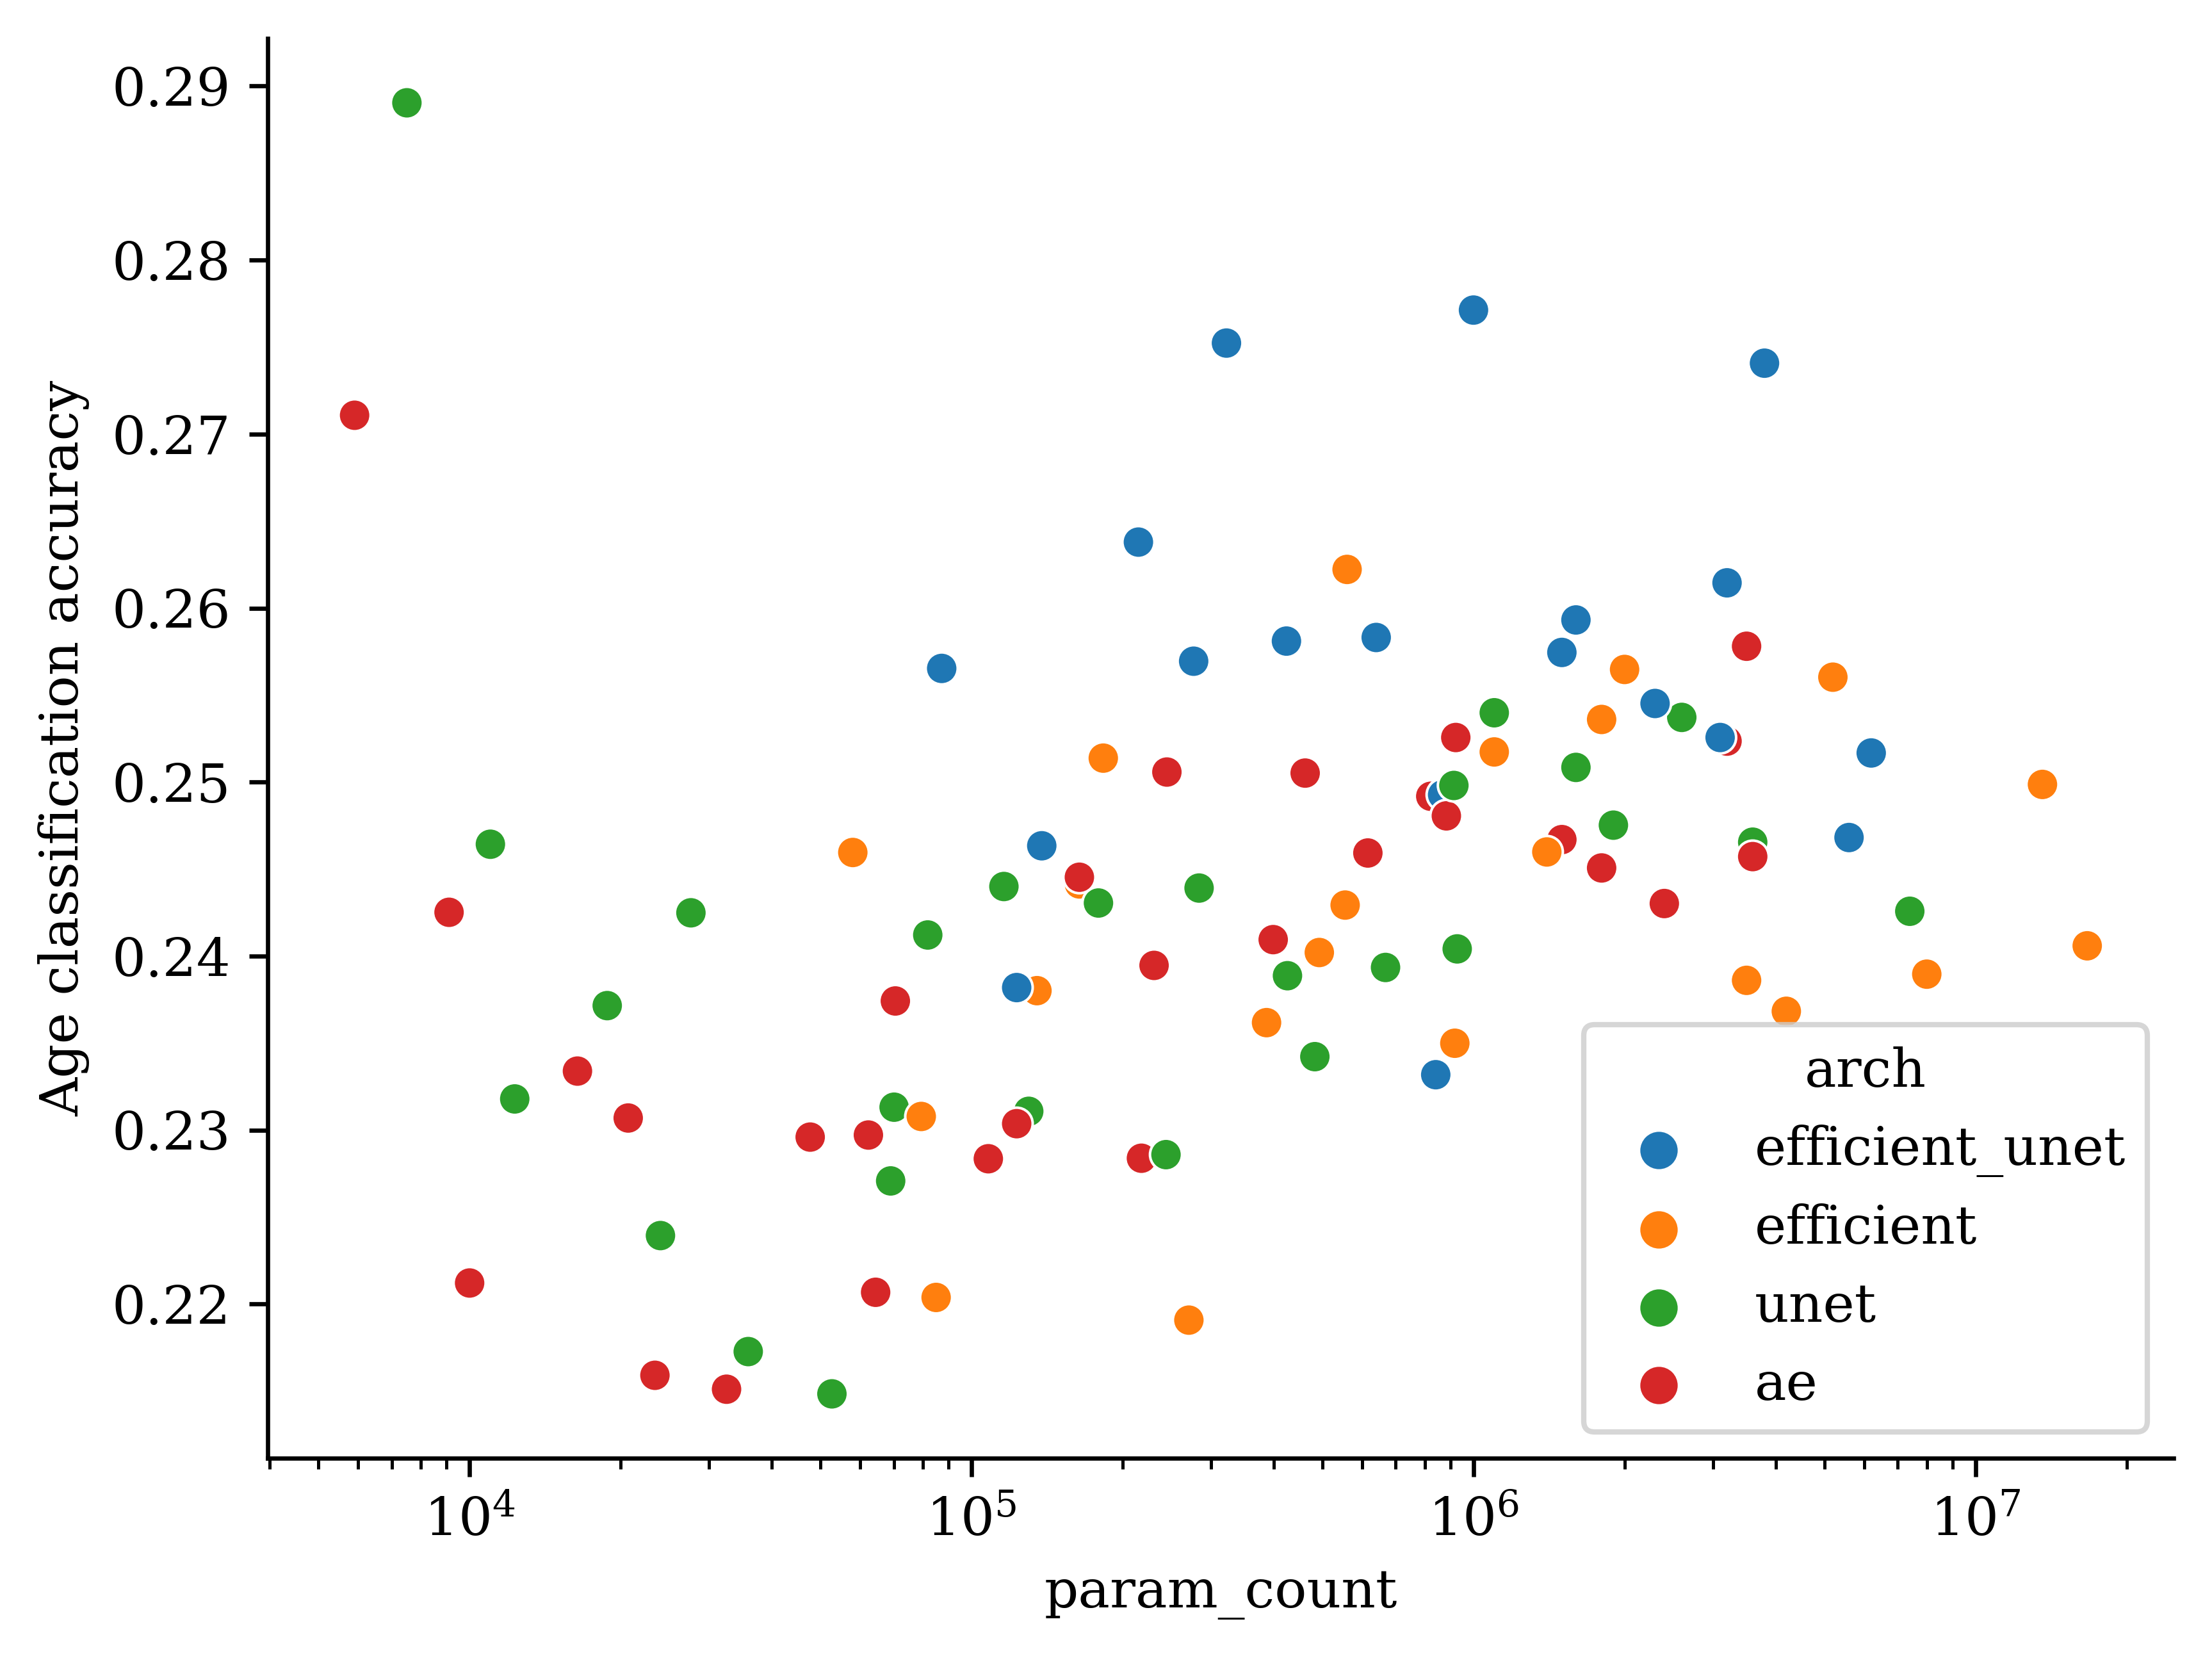

In [36]:
ax = sns.scatterplot(
    data=results.query("epoch == 100"), x="param_count", y="age_class", hue="arch"
)
ax.set(xscale="log", ylabel="Age classification accuracy")
sns.despine()

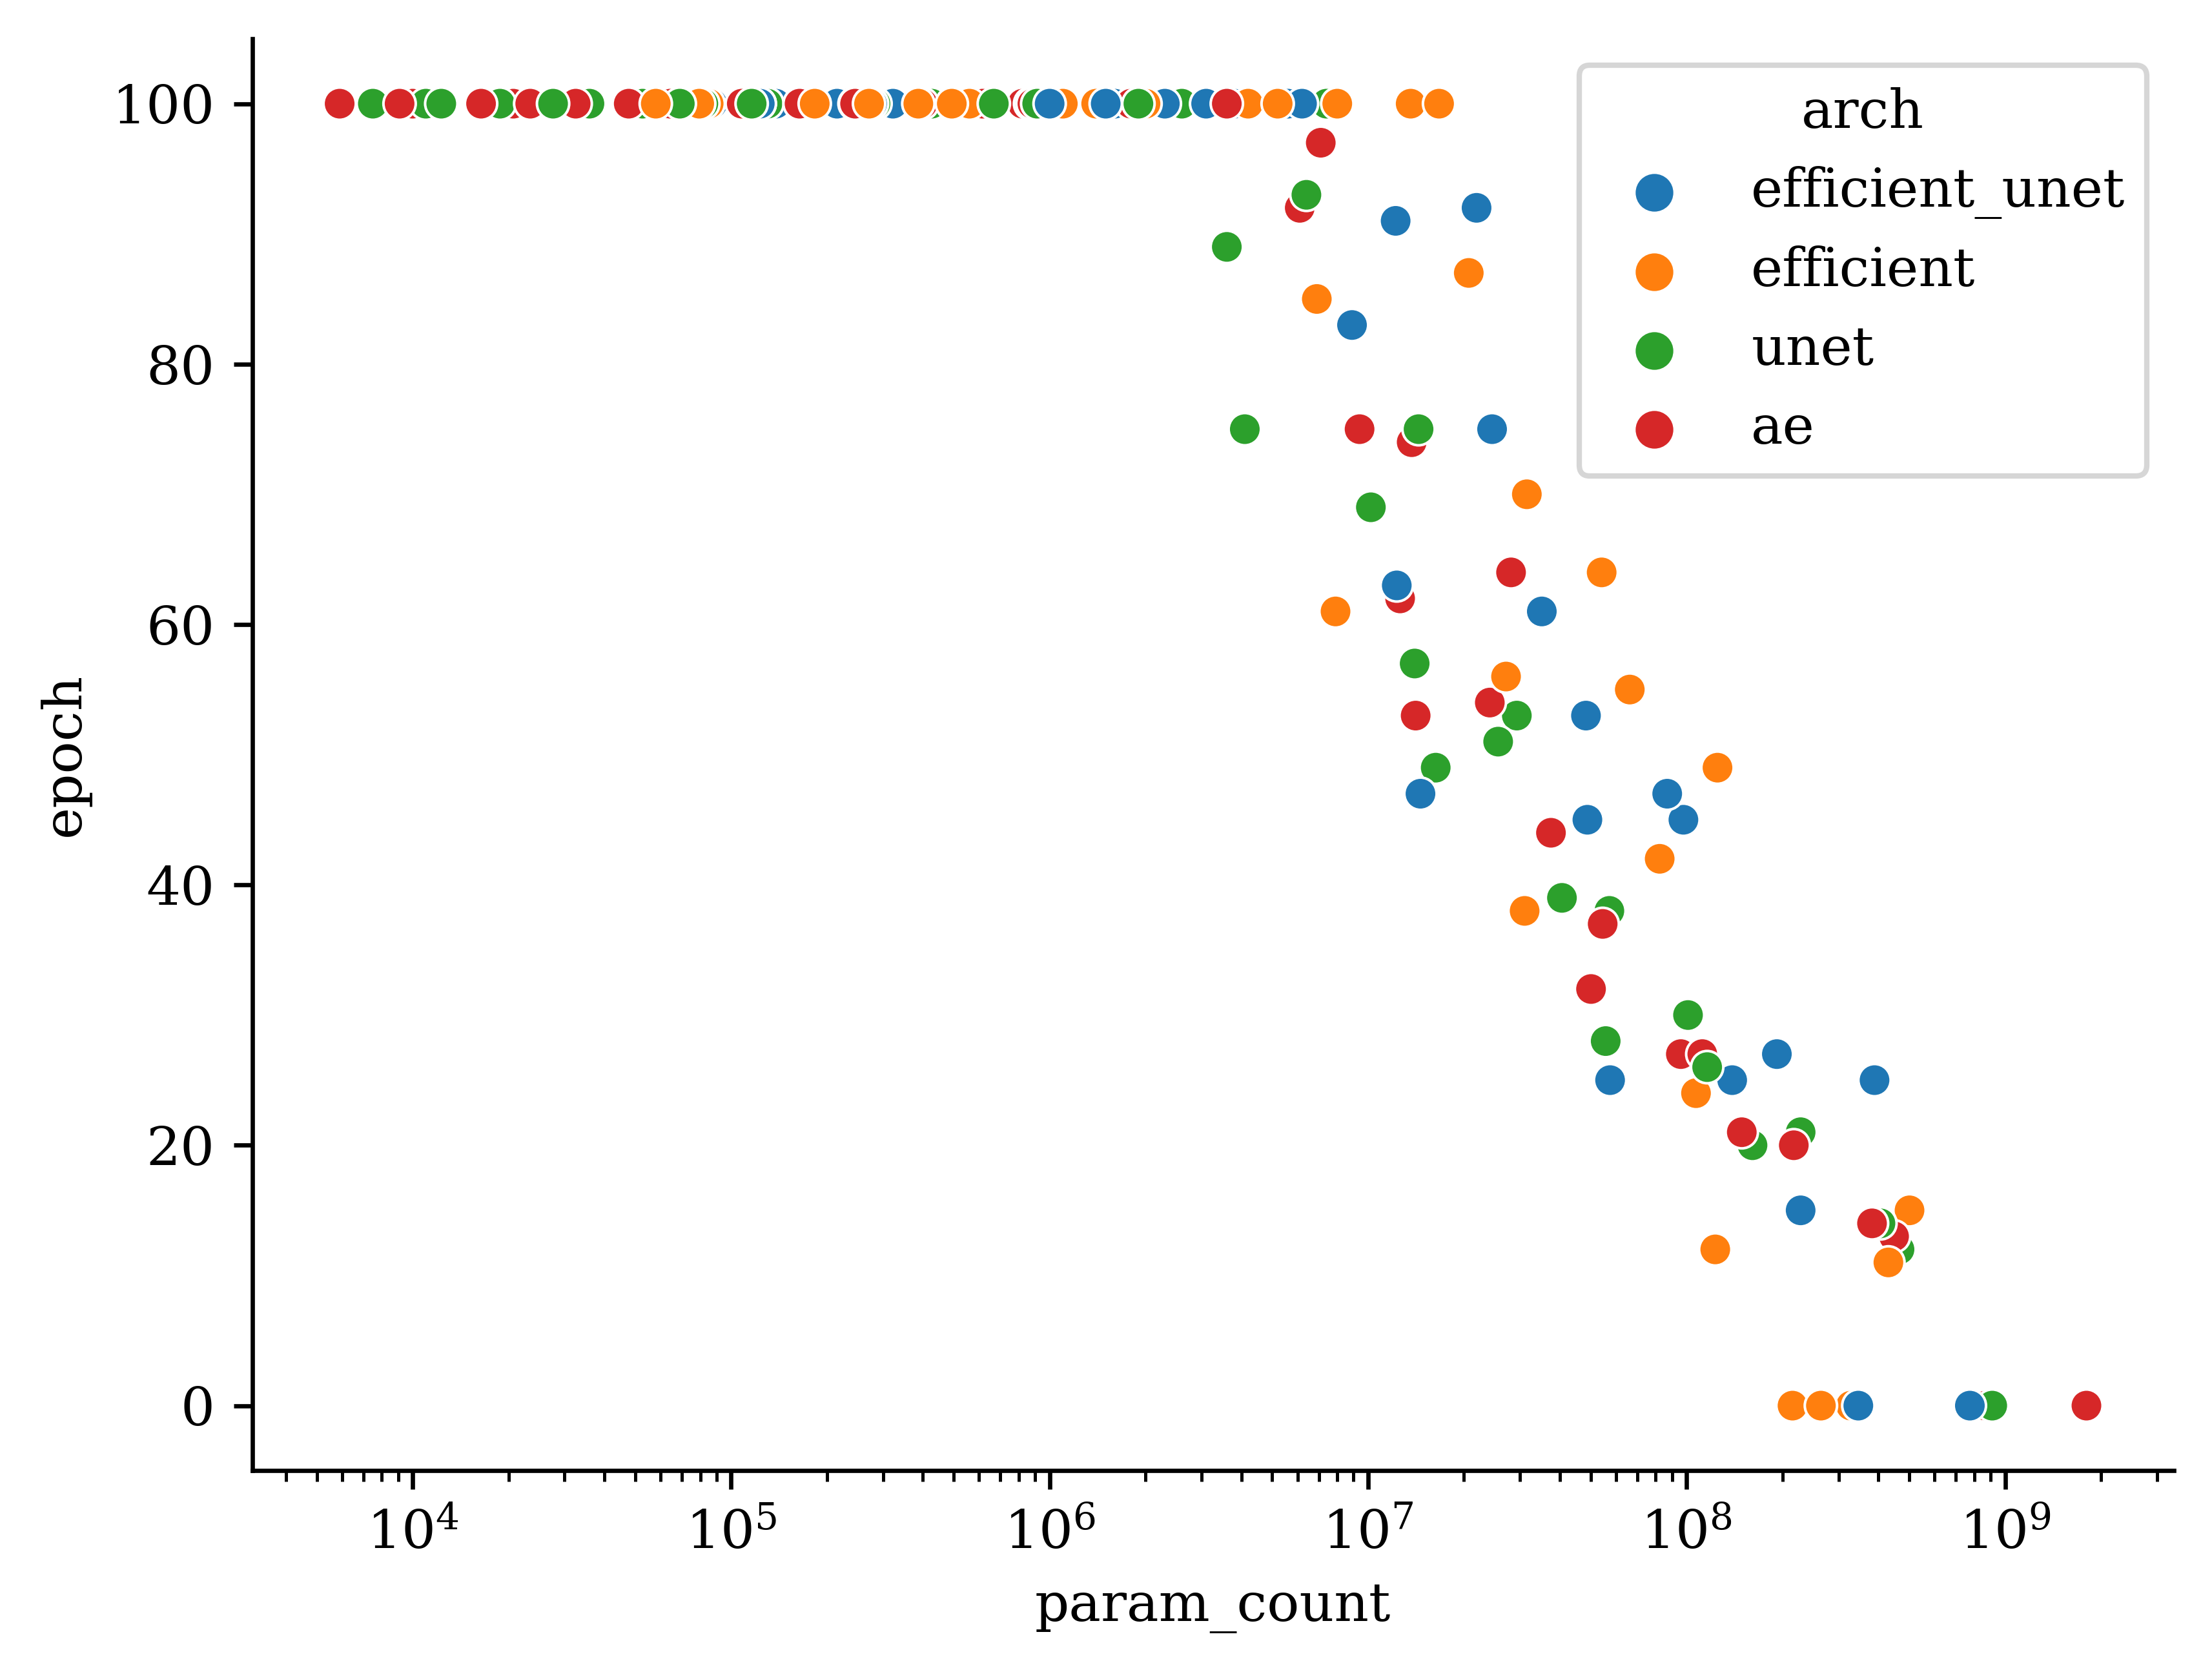

In [37]:
ax = sns.scatterplot(data=results, x='param_count', y='epoch', hue='arch')
ax.set(xscale='log')
sns.despine()

In [42]:
comp = results.query('epoch == 100').sort_values(by='val_mse')

In [45]:
comp['dyn_loss'] = 1 - comp['dynamics_corr']

In [58]:
comp['total_loss'] = comp['val_mse'] + (2e-3 * comp['dyn_loss']) + (1e-3 * comp['age_class'])

In [59]:
comp.sort_values(by='total_loss').head(10)

,depth,arch,channel_scaling,depth_scaling,init_depth,init_channel,val_mse,uuid,train_mse,epoch,param_count,file,dynamics_corr,age_class,dyn_loss,total_loss
155,4,ae,1.5,1.0,1,256,0.000546,fbe6efe5-9c3a-4228-b643-e16f3520f893,0.000506,100,3600000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.835525,0.245719,0.164475,0.001121
35,4,unet,2.5,1.0,1,64,0.000583,f026ff89-de2b-4789-9985-f4cc02179b0b,0.000533,100,2600000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.847298,0.253719,0.152702,0.001142
56,4,ae,2.0,1.0,1,128,0.000570,7813e357-209c-4a74-a4b6-dcea5f01edf6,0.000529,100,3200000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.838870,0.252356,0.161130,0.001145
8,4,unet,4.0,1.0,1,32,0.000583,edbb632f-0282-43e2-ac11-3a50b84867dc,0.000534,100,7400000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.837634,0.242578,0.162366,0.001151
14,4,ae,2.5,1.0,1,64,0.000582,11f514a0-6495-4984-88df-f6fccb23ebe7,0.000566,100,2400000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.837199,0.243022,0.162801,0.001151
39,4,ae,3.5,1.0,1,32,0.000584,bb96dbf8-854f-4835-9820-584a1f2d8719,0.000548,100,3500000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.842150,0.257807,0.157850,0.001157
60,4,unet,3.5,1.0,1,32,0.000595,d02832f9-cd85-404f-8d87-b51e8e4c187c,0.000581,100,3600000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.840242,0.246548,0.159758,0.001161
73,4,efficient_unet,1.5,1.0,1,64,0.000556,951380f4-3949-427e-8b9c-a11242c57526,0.000515,100,3800000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.827739,0.274074,0.172261,0.001175
106,4,ae,1.5,1.0,1,128,0.000605,39b610c2-b574-40a0-9180-3757db8d1f2b,0.000575,100,922000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.841492,0.252563,0.158508,0.001175
75,4,efficient,3.0,1.0,1,32,0.000564,181e203c-1ef2-4b51-8816-92249378ec7c,0.000539,100,13600000.0,/n/groups/datta/win/longtogeny/size_norm/model...,0.815976,0.249867,0.184024,0.001182
